# House Prices: Advanced Regression Techniques
- Kaggle 連結: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# 參考資料
- https://www.itread01.com/content/1566389045.html
- https://medium.com/%E7%84%A1%E9%82%8A%E6%8B%BC%E5%9C%96%E6%A1%86/kaggle-house-price-prediction-competition-%E5%AF%A6%E6%88%B0-ff1c846a9f14
- https://github.com/AdamYuCheng/Machine-Learning/tree/master/Kaggle%20House%20Prediction
- https://zhuanlan.zhihu.com/p/139719435

# Kaggle資料串接
直接從Kaggle串資料，已用我的json串接(省略每次上傳步驟，需要可以直接摳)

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
import os
os.environ['KAGGLE_USERNAME'] = "crazyryan" # username from the json file
os.environ['KAGGLE_KEY'] = "5fc8be3d6107fcff71a432a4fa59b172" # key from the json file

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


# 資料讀取

In [ ]:
# 請勿更動此區塊程式碼

import time

EXECUTION_START_TIME = time.time() # 計算執行時間

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%pylab inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'sample', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


 **讀取資料**

In [ ]:
train_path = os.path.abspath('train.csv')
test_path = os.path.abspath('test.csv')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("訓練資料大小：",train.shape)
print("測試資料大小：",test.shape)

訓練資料大小： (1460, 81)
測試資料大小： (1459, 80)


In [ ]:
#用不到ID 先將其保存後從資料及刪除
train_id=train['Id']
test_id=test['Id']
train=train.drop(columns='Id')
test=test.drop(columns='Id')
#合併訓練和測試資料，以方便做資料處理
combine= pd.concat([train, test], axis=0, ignore_index=True)
#取出SalePrice(即我們要預測的column，並從combine中刪除)
saleprice=train['SalePrice']
combine=combine.drop(columns='SalePrice')
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

可以看到資料集明顯有許多columns都有缺失值

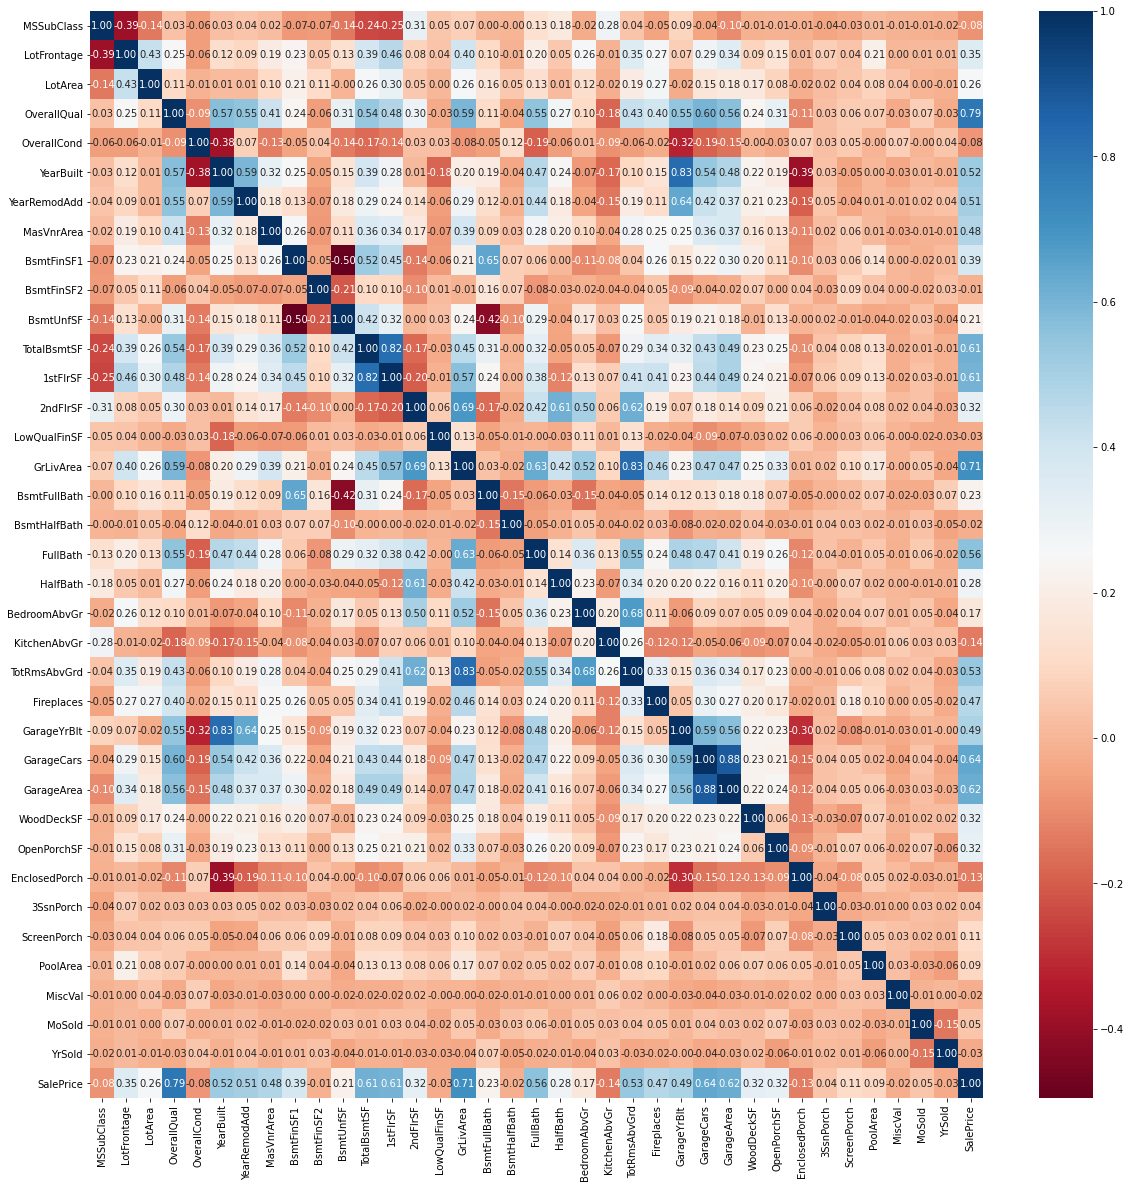

In [ ]:
plt.figure(figsize=(20, 20))
train_corr = train.corr()
sns.heatmap(train_corr, annot=True, fmt = ".2f" ,cmap='RdBu')



*   大部分特徵都和SalePrice正相關


*   OverallQual,GrLivArea和SalePrice相關度極高





# **資料清洗**

**缺失值處理**

In [ ]:
#查看缺失值
missing=combine.isnull().sum()
missing_percent=100*(missing/combine.shape[0])
missing_df=pd.DataFrame({'missing':missing,'missing_percent%':missing_percent})
missing_df=missing_df[missing_df['missing']!=0].sort_values('missing',ascending=False)
missing_df

,missing,missing_percent%
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071
GarageYrBlt,159,5.447071




*   PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage這些的是缺失值較多的特徵
*   Garage：和車庫有關的特徵有一樣的缺失值
*   Bsmt:和地下室有關的特徵有一樣的缺失值





In [ ]:
#處理缺失值
#用眾數去處理填缺失值
combine = combine.drop(['Utilities'], axis=1)
combine['Functional']=combine['Functional'].fillna("Typ")
combine['Electrical']=combine['Electrical'].fillna(combine['Electrical'].mode()[0])
combine['KitchenQual'] = combine['KitchenQual'].fillna(combine['KitchenQual'].mode()[0])
combine['Exterior1st'] = combine['Exterior1st'].fillna(combine['Exterior1st'].mode()[0])
combine['Exterior2nd'] = combine['Exterior2nd'].fillna(combine['Exterior2nd'].mode()[0])
combine['SaleType'] = combine['SaleType'].fillna(combine['SaleType'].mode()[0])
#MSZoning和MSSubClass有關，用分组後的數填缺失值
combine['MSZoning'] = combine.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# LotFrontage和Neighborhood相關，用分组后的中位数替代
combine['LotFrontage'] =combine.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#用0取代Garage的數值型特徵
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars'] :
   combine[col] = combine[col].fillna(0)
#用None取代Garage的文字型特徵
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
  combine[col]=combine[col].fillna('None')
#用None替代地下室的文字型特徵 
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    combine[col] = combine[col].fillna('None')  

#剩下的數值型特徵無意義，用0取代
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in combine.columns:
  if combine[i].dtype in numeric_dtypes:
    numeric.append(i)
combine.update(combine[numeric].fillna(0))   
#剩下的文字型特徵無無意義，用0取代
objects=[]
for i in combine.columns:
  if combine[i].dtype== object:
    objects.append(i)
combine.update(combine[objects].fillna('None'))
#刪除缺失值80%以上的特徵
#combine.drop(columns=['PoolQC','MiscFeature','Alley','Fence'],inplace=True)


In [ ]:
combine.isnull().sum().value_counts()

0    78
dtype: int64

**異常值處理**

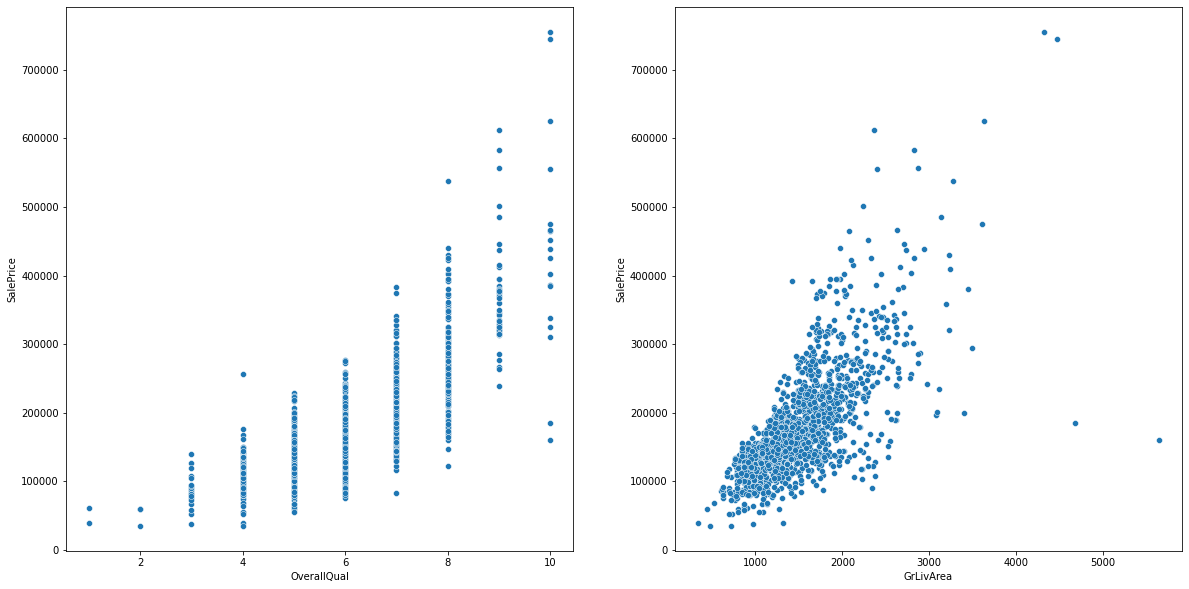

In [ ]:
#選用上面兩個相關度極高的特徵來繪製分佈圖，以尋找離群值
cols=['OverallQual','GrLivArea']
fig,ax=plt.subplots(1,2,figsize=(20,10))
index=0
for col in cols:
  sns.scatterplot(x=train[col],y=train['SalePrice'],ax=ax[index])
  index+=1



*   OverallQual=4時有一個離群值
*   GriLivArea有兩個面積大saleprice卻低得離群值



In [ ]:
#刪除離群值
outlier1 = train[(train['OverallQual']==4) & (train['SalePrice']>200000)].index.tolist()
outlier2 = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index.tolist()
outliers = list(set(outlier1+outlier2))
# 特徵矩陣以及saleprice都需要删除
combine.drop(index=outliers, inplace=True)
saleprice.drop(index=outliers, inplace=True)
# 重置索引
combine.reset_index(drop=True, inplace=True)
saleprice.reset_index(drop=True, inplace=True)


In [ ]:
combine.shape

(2916, 78)

**區分數字型和文字型特徵**

In [ ]:
#找到數字型特徵
num_col=combine._get_numeric_data().columns.tolist()
#找到文字型特徵
catogo_col=set(combine.columns)-set(num_col)

#算每一個文字型特徵的total value
for i in catogo_col:
  print(combine[i].value_counts())

Y    2720
N     196
Name: CentralAir, dtype: int64
Reg    1859
IR1     966
IR2      76
IR3      15
Name: LotShape, dtype: int64
Typ     2717
Min2      70
Min1      64
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
TA    2535
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64
Norm      2510
Feedr      163
Artery      92
RRAn        50
PosN        38
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64
TA      2651
None     159
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64
TA      1283
Gd      1208
Ex       256
Fa        88
None      81
Name: BsmtQual, dtype: int64
SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
TA    1493
Gd    1150
Ex     203
Fa      70
Name: KitchenQual, dtype: int64
TA      2601
None     159
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64
None    28

# **EDA**

EDA的目的有：


*   SalePrice的分布為何？
*   特徵和SalePrice的相關性
*   特徵間的相關性






**SalePrice分佈**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
        1000000.]), <a list of 7 Text major ticklabel objects>)

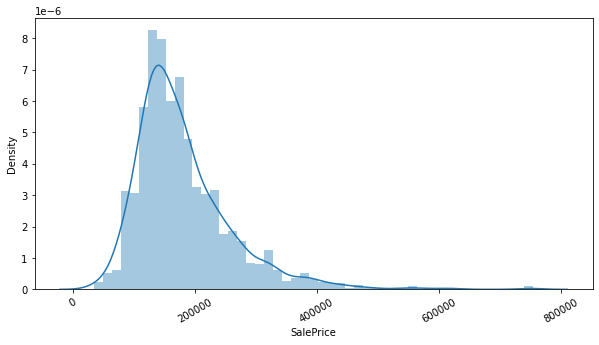

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train['SalePrice'])
plt.xticks(rotation=30)



*   可發現SalePrice非normal distribution，後面需要處理


**特徵之間的相關性**

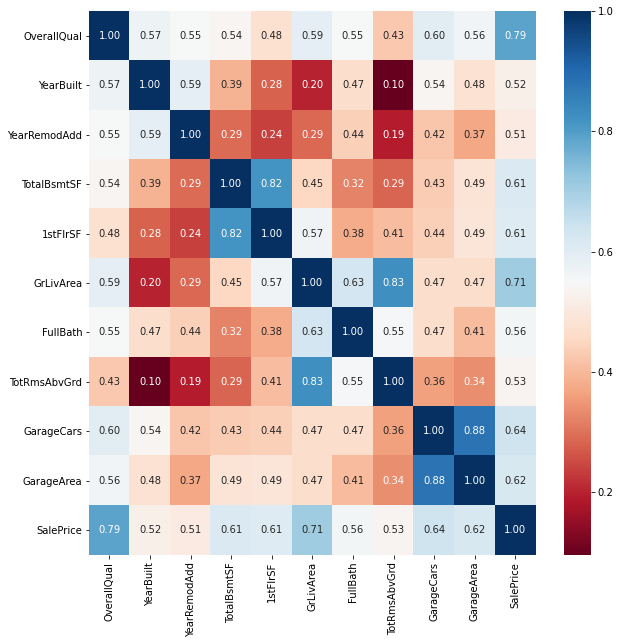

In [ ]:
#因特徵太多，取和saleprice相關的絕對值>0.5的來畫圖
plt.figure(figsize=(10,10))
corrnum=train.corr()
top_cols = corrnum.index[abs(corrnum["SalePrice"])>0.5]
train_corr_top=train.loc[:,top_cols].corr()
sns.heatmap(train_corr_top,annot=True, fmt = ".2f",cmap='RdBu')



*   OverallQual,GrLivArea,GarageCars和SalePrice的相關度極高
*   部分特徵間也存在很高相關度：
    - GarageCars & GarageArea
    - TotRmsAbvGrd和GrLivArea
* 由此可知此資料集可能為多變量線性回歸，應盡量避免使用線性回歸模型




# **特徵工程**

**創建新特徵**


把一些有關係的特徵組合

In [ ]:
#創造新特徵
combine['TotalSF'] = combine['TotalBsmtSF'] + combine['1stFlrSF'] + combine['2ndFlrSF']
combine['YrSinceRemod'] = combine['YrSold'].astype(int) - combine['YearRemodAdd'].astype(int)
combine['YrSinceBuilt'] = combine['YrSold'].astype(int) - combine['YearBuilt'].astype(int)
combine['OverallEval'] = combine['OverallQual'] + combine['OverallCond']
combine['LowQualPct'] = combine['LowQualFinSF'] / combine['TotalSF']
combine['funcSF'] = combine['WoodDeckSF'] + combine['OpenPorchSF'] + combine['EnclosedPorch'] + combine['3SsnPorch'] +combine['ScreenPorch'] + combine['PoolArea']


**有順序的特徵編碼**

有些文字型特徵的值是有順序的，無法用one-hot encoding

In [ ]:
order_map={'Ex':0,'Gd':1,'TA':2,'Fa':3,'Po':4,'None':5}
order_cols=['BsmtCond','BsmtQual','ExterCond','ExterQual','FireplaceQu',
            'GarageCond','GarageQual','HeatingQC','KitchenQual']
for col in order_cols:
  combine[col]=combine[col].map(order_map).astype(int)

 **修正資料類型**

將一些數字型特徵修改成文字型（避免後續拿來做計算）

In [ ]:
combine['OverallCond'] = combine['OverallCond'].astype(object)
combine['MSSubClass'] = combine['MSSubClass'].astype(object)
combine['YrSold'] = combine['YrSold'].astype(object)
combine['MoSold'] = combine['MoSold'].astype(object)


**時間類型的特徵編碼**

將有順序性的時間進行編碼

In [ ]:
from sklearn.preprocessing import LabelEncoder
time_cols = ['GarageYrBlt','YearBuilt','YearRemodAdd','YrSold']
for col in time_cols:
    combine[col] = LabelEncoder().fit_transform(combine[col])

**數字型特徵的變換**

觀察數值型特徵的分佈，看其是否符合normal disribution

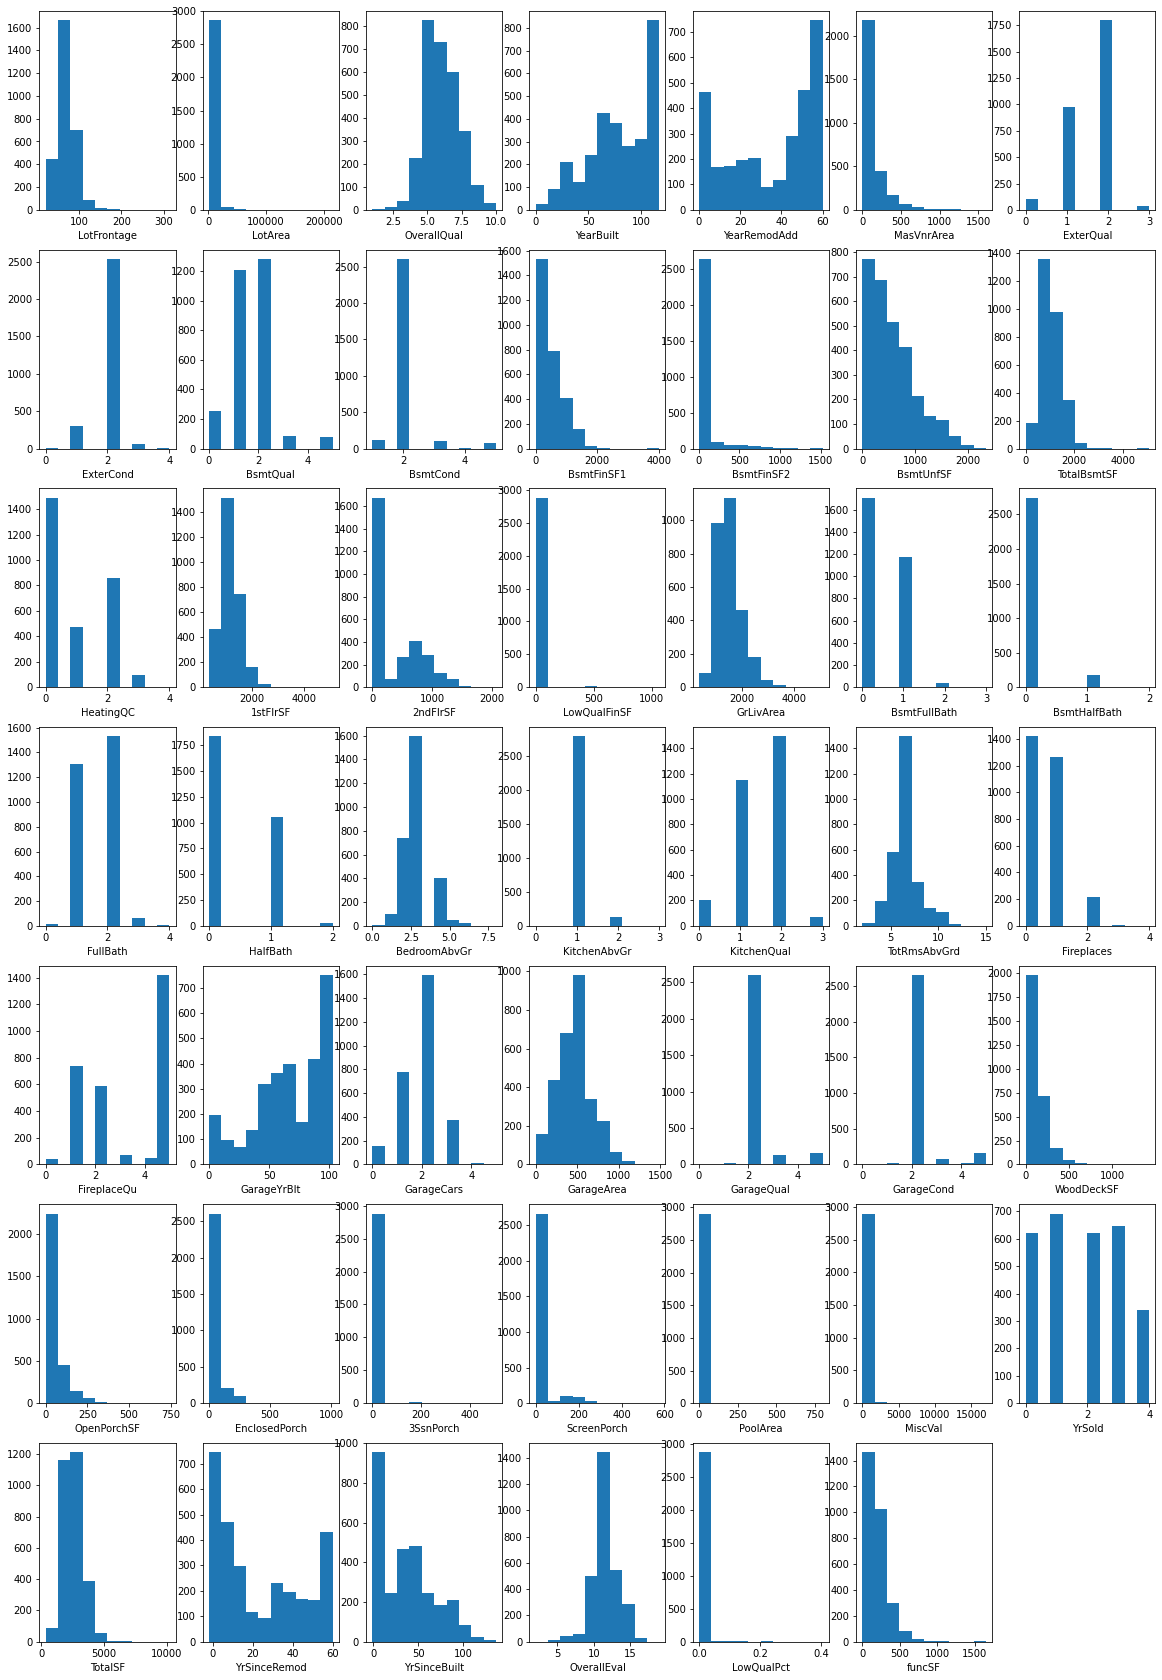

In [ ]:
#找到數字型特徵
num_cols=combine._get_numeric_data().columns.tolist()

#畫圖去看特徵的值的分佈
fig = plt.figure(figsize=(20, 30))
for col in num_cols:
    ax = fig.add_subplot(7, 7, num_cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(combine[col])


In [ ]:
# 計算skewed的量
skewed_cols = combine[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'skewed':skewed_cols})
skewed_df

,skewed
MiscVal,21.935910
PoolArea,17.685603
LotArea,13.262550
LowQualFinSF,12.082427
LowQualPct,11.610221
3SsnPorch,11.370087
KitchenAbvGr,4.299698
BsmtFinSF2,4.143683
EnclosedPorch,4.001570
ScreenPorch,3.944305


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


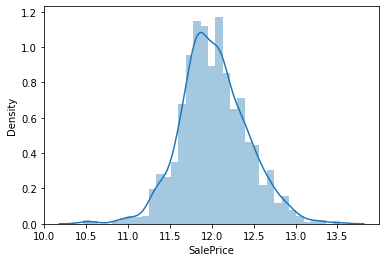

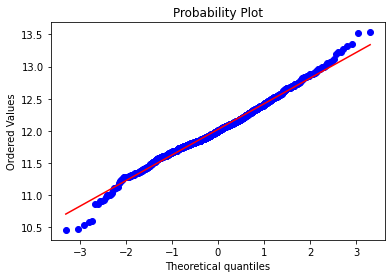

In [ ]:
#skewed偏度的絕對值>1的特徵作對數變換
skewed_cols = skewed_df[skewed_df['skewed'].abs()>1].index.tolist()
for col in skewed_cols:
    combine[col] = np.log1p(combine[col])

#SalePrice也不是normal distribution，一樣進行對數變換
saleprice = np.log1p(saleprice)
sns.distplot(saleprice)
fig = plt.figure()
res = stats.probplot(saleprice, plot=plt)

**One-Hot  encoding**

In [ ]:
#把剩下的文字性特徵編碼
combine= pd.get_dummies(combine)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Columns: 302 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(30), int64(18), uint8(254)
memory usage: 1.8 MB


**還原訓練和測試資料集**

In [ ]:
train_clean=combine.iloc[:1457,:]
test_clean=combine.iloc[1457:,:]
train_clean=pd.concat([train_clean,saleprice],axis=1)
print(train_clean.shape)
print(test_clean.shape)

(1457, 303)
(1459, 302)


# **模型建立**

**導入套件**

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

**建模**

In [ ]:
#劃分資料集
X=train_clean.drop(columns='SalePrice')
Y=train_clean['SalePrice']

X_train, X_test, Y_train, Y_test =train_test_split(X,Y,train_size=0.7,random_state=10)
print(X_train.shape) 
print(X_test.shape) 
print(Y_train.shape) 
print(Y_test.shape) 

(1019, 302)
(438, 302)
(1019,)
(438,)


In [ ]:
#交叉驗證
kf = KFold(n_splits=10, random_state=50, shuffle=True)
def rmse(y, y_pred):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def cv_rmse(model, X=X_test,Y=Y_test):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=kf))
    return rmse
#建立regression模型
lgb = LGBMRegressor(objective='regression', random_state=50)
xgb = XGBRegressor(objective='reg:linear', random_state=50, silent=True)
rf = RandomForestRegressor(random_state=50)

**模型參數優化**

用GridSearch來將參數優化

In [ ]:
#優化後的模型
best_lgb = LGBMRegressor(objeactive='regression'
                    ,n_estimators=1200
                    ,max_depth=8
                    ,num_leaves=10
                    ,min_data_in_leaf=3
                    ,max_bin=25
                    ,bagging_fraction=0.6
                    ,bagging_freq=11
                    ,feature_fraction=0.6
                    ,learning_rate=0.01
                    ,random_state=50
                    ,n_jobs=4)

best_xgb = XGBRegressor(objective='reg:linear'
                   ,n_estimators=2200
                   ,learning_rate=0.05
                   ,max_depth=3
                   ,subsample=0.6
                   ,min_child_weight=3
                   ,colsample_bytree=0.5
                   ,random_state=50
                   ,n_jobs=4
                   ,silent=True)

best_rf = RandomForestRegressor(n_estimators=70,
                           min_impurity_decrease=0.002,
                           min_weight_fraction_leaf=0.001,
                           min_samples_split=5,
                           random_state=50,
                           n_jobs=4)

In [ ]:
#模型優化後評估
best_models=[best_lgb,best_xgb,best_rf]
best_model_names=[best_lgb,best_xgb,best_rf]
scores = {}
for i, model in enumerate(best_models):
  score=cv_rmse(model)
  scores[best_model_names[i]] = (score.mean(), score.std())

scores_df=pd.DataFrame(scores,index=['rmse_score','rmse_std'])
scores_df.sort_values('rmse_score', axis=1, inplace=True)
scores_df

,"LGBMRegressor(bagging_fraction=0.6, bagging_freq=11, boosting_type='gbdt',\n class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,\n importance_type='split', learning_rate=0.01, max_bin=25,\n max_depth=8, min_child_samples=20, min_child_weight=0.001,\n min_data_in_leaf=3, min_split_gain=0.0, n_estimators=1200,\n n_jobs=4, num_leaves=10, objeactive='regression', objective=None,\n random_state=50, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n subsample=1.0, subsample_for_bin=200000, subsample_freq=0)","XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=0.5, gamma=0,\n importance_type='gain', learning_rate=0.05, max_delta_step=0,\n max_depth=3, min_child_weight=3, missing=None, n_estimators=2200,\n n_jobs=4, nthread=None, objective='reg:linear', random_state=50,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\n silent=True, subsample=0.6, verbosity=1)","RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n max_samples=None, min_impurity_decrease=0.002,\n min_impurity_split=None, min_samples_leaf=1,\n min_samples_split=5, min_weight_fraction_leaf=0.001,\n n_estimators=70, n_jobs=4, oob_score=False,\n random_state=50, verbose=0, warm_start=False)"
rmse_score,0.121421,0.123728,0.168598
rmse_std,0.021841,0.022852,0.029766


In [ ]:
d = {'XGBRegressor': [0.1214	, 0.0172	], 'LGBMRegressor': [0.1099	, 0.0170],'RandomForestRegressor': [0.1764, 0.0142]}
pd.DataFrame(data = d, index = ['rmse_score', 'rmse_std'])

,XGBRegressor,LGBMRegressor,RandomForestRegressor
rmse_score,0.1214,0.1099,0.1764
rmse_std,0.0172,0.0170,0.0142


**選用best_xgb作為最終模型**

In [ ]:
'''best_xgb.fit(X,Y)
Y_pred = np.exp(best_xgb.predict(test_clean)) - 1
sample = pd.read_csv('sample_submission.csv')
sample['SalePrice'] = Y_pred
sample.to_csv('result.csv', index=False)'''

"best_xgb.fit(X,Y)\nY_pred = np.exp(best_xgb.predict(test_clean)) - 1\nsample = pd.read_csv('sample_submission.csv')\nsample['SalePrice'] = Y_pred\nsample.to_csv('result.csv', index=False)"

In [ ]:
EXECUTION_END_TIME = time.time() # 計算執行時間
print('total execution time: {}'.format(EXECUTION_END_TIME - EXECUTION_START_TIME))

total execution time: 210.23028945922852


# **模型ensemble**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model, X=X,Y=Y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08605262760580601, tolerance: 0.016162624920409305
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03336717513753129, tolerance: 0.015422544536433009
  positive)



Lasso score: 0.1023 (0.0050)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05743883678582584, tolerance: 0.01609529886461114
  positive)


In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07496661880279021, tolerance: 0.016162624920409305
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02886511292386551, tolerance: 0.015422544536433009
  positive)


ElasticNet score: 0.1023 (0.0051)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04789681630399123, tolerance: 0.01609529886461114
  positive)


In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.2686 (0.0192)



In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.1085 (0.0040)



In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1071 (0.0034)



In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1078 (0.0023)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, Y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, Y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, Y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, Y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], Y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, Y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost),meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(X.values, Y)
stacked_train_pred = stacked_averaged_models.predict(X.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_clean).values)
print(rmsle(Y, stacked_train_pred))

In [ ]:
lasso.fit(X_train, Y_train)
lasso_train_pred = lasso.predict(X_test)
lasso_pred = np.expm1(lasso.predict(test_clean))
print(rmsle(Y_test, lasso_train_pred))

0.10776026007473802


In [ ]:
model_xgb.fit(X_train, Y_train)
xgb_train_pred = model_xgb.predict(X_test)
xgb_pred = np.expm1(model_xgb.predict(test_clean))
print(rmsle(Y_test, xgb_train_pred))

0.11152550594096204


In [ ]:
ENet.fit(X_train, Y_train)
ENet_train_pred = ENet.predict(X_test)
ENet_pred = np.expm1(ENet.predict(test_clean))
print(rmsle(Y_test, ENet_train_pred))

0.10759665732504935


In [ ]:
GBoost.fit(X_train, Y_train)
GBoost_train_pred = GBoost.predict(X_test)
GBoost_pred = np.expm1(GBoost.predict(test_clean))
print(rmsle(Y_test, GBoost_train_pred))

0.11651227545625209


In [ ]:
model_lgb.fit(X_train, Y_train)
lgb_train_pred = model_lgb.predict(X_test)
lgb_pred = np.expm1(model_lgb.predict(test_clean))
print(rmsle(Y_test, lgb_train_pred))

0.11628574092942798


**比較各模型的RMSE和ensemble之後的RMSE**

In [ ]:
d = {'XGBRegressor': [0.1205], 'LGBMRegressor': [0.1216], 'lasso': [0.1154], 'ElasticNet': [0.1156], 'GradientBoostingRegressor': [0.1208]}
pd.DataFrame(data = d, index = ['rmse_score'])

,XGBRegressor,LGBMRegressor,lasso,ElasticNet,GradientBoostingRegressor
rmse_score,0.1205,0.1216,0.1154,0.1156,0.1208


In [ ]:
d = {'ensemble': [0.1138]}
pd.DataFrame(data = d, index = ['rmse_score'])

,ensemble
rmse_score,0.1138


In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(Y_test,GBoost_train_pred*0.2 + xgb_train_pred*0.2 + lgb_train_pred*0.2 + ENet_train_pred*0.2 + lasso_train_pred*0.2))
print(rmsle(Y_test,GBoost_train_pred*0.26 + xgb_train_pred*0.08 + lgb_train_pred*0.07 + ENet_train_pred*0.29 + lasso_train_pred*0.30))

RMSLE score on train data:
0.10709788066532136
0.10626760143483521


In [ ]:
ensemble = GBoost_pred*0.2 + xgb_pred*0.2 + lgb_pred*0.2 + ENet_pred*0.2 + lasso_pred*0.2

In [ ]:
pd.DataFrame(ensemble)

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample['SalePrice'] = ensemble
sample.to_csv('result.csv', index=False)